# Lab 6

Name:

Date: 

**As you work through the code below, respond to all in-line comments and questions.**

First,  switch to a GPU enable runtime environment.  Second, specify the path to the raw data.  This will be provided by the instructor.


In [ ]:
FISHY_URL=''
print(FISHY_URL)

The data set is quite large.  So execute this cell only once to save bandwidth.  

In [ ]:
!mkdir /opt/lab6-storage

!wget $FISHY_URL --no-check-certificate \
    -O /opt/lab6-storage/folds-w-meta.pkl

In [ ]:
!ls -al /opt/lab6-storage/folds-w-meta.pkl


-rw-r--r-- 1 root root 946285797 Sep 29 17:25 /opt/lab6-storage/folds-w-meta.pkl


In [ ]:
# Load 

import numpy as np
import sys
import pickle

with open('/opt/lab6-storage/folds-w-meta.pkl', "rb") as f:
        pd_folds = pickle.load(f, encoding='latin1')

train = {'data': pd_folds[0]['data'], 'class': pd_folds[0]['class'],
         'id': pd_folds[0]['id'], 'source': pd_folds[0]['source'],
         'length': pd_folds[0]['length'], 'girth': pd_folds[0]['girth'], 'weight': pd_folds[0]['weight']}


val = {'data': pd_folds[9]['data'], 'class': pd_folds[9]['class'],
         'id': pd_folds[9]['id'], 'source': pd_folds[9]['source'],
         'length': pd_folds[9]['length'], 'girth': pd_folds[9]['girth'], 'weight': pd_folds[9]['weight']}

for fold in pd_folds[1:8]:
    train['data'] = np.concatenate((train['data'], fold['data']))
    train['class'].extend(fold['class'])
    train['id'].extend(fold['id'])
    train['source'].extend(fold['source'])
    train['length'].extend(fold['length'])
    train['girth'].extend(fold['girth'])
    train['weight'].extend(fold['weight'])

species = set(train['class']).union(set(val['class'])) # Get a set with all species
print(species)

class_map = dict(zip(species, range(len(species)))) # Create a map that convert label to number
print(class_map)

train_X = train['data'].reshape((-1, 75, 200, 3))
train_Y = np.array([class_map[species] for species in np.repeat(train['class'], 9)], dtype=np.int32)
#train_Y = np.array(np.repeat(train['length'], 9))

val_X = val['data'].reshape((-1, 75, 200, 3))
val_Y = np.array([class_map[species] for species in np.repeat(val['class'], 9)], dtype=np.int32)
#val_Y = np.array(np.repeat(val['length'], 9))

# Check the distribution the targets



{'LNG', 'GS', 'NP', 'WP', 'SMB', 'WB', 'NHS', 'SC', 'LNS', 'GC', 'WYE', 'RHS', 'QBS', 'GF', 'CWS', 'CC', 'BUF', 'RRS', 'SL', 'BHC', 'FWD', 'CCF'}
{'LNG': 0, 'GS': 1, 'NP': 2, 'WP': 3, 'SMB': 4, 'WB': 5, 'NHS': 6, 'SC': 7, 'LNS': 8, 'GC': 9, 'WYE': 10, 'RHS': 11, 'QBS': 12, 'GF': 13, 'CWS': 14, 'CC': 15, 'BUF': 16, 'RRS': 17, 'SL': 18, 'BHC': 19, 'FWD': 20, 'CCF': 21}


If you are going to attempt the classification task, you need to one hot encode the targets.

In [ ]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

from keras import utils

train_Y = np.array([class_map[species] for species in np.repeat(train['class'], 9)], dtype=np.int32)
val_Y = np.array([class_map[species] for species in np.repeat(val['class'], 9)], dtype=np.int32)

train_Y = to_one_hot(train_Y, dimension=22)
val_Y = to_one_hot(val_Y, dimension=22)

print(train_Y)
print(val_Y)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Visualize the a few images.

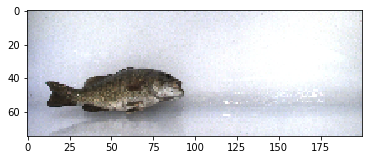

In [ ]:
from matplotlib.pyplot import imshow
%matplotlib inline

imshow(train_X[1,:], interpolation='nearest')

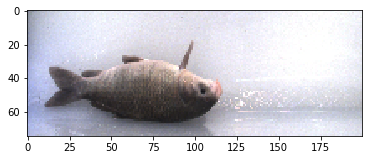

In [ ]:
from matplotlib.pyplot import imshow
%matplotlib inline

imshow(train_X[10,:], interpolation='nearest')

Train up some models.

In [ ]:
# Model here ...

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.datasets import mnist
from keras import utils

# Convolutional layers
cnn_model = Sequential()
cnn_model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(75, 200, 3)))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))

# Dense, fully connected layers
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(22, activation='softmax'))

# Specify the loss, optimizer and any additional metrics to follow
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with the training data, set epochs and batch size
cnn_model.fit(train_X, train_Y, epochs=10, batch_size=32, validation_data=(val_X, val_Y))

Epoch 1/10
141/141 [==============================] - 2s 12ms/step - loss: 4.8047 - accuracy: 0.3932 - val_loss: 1.5846 - val_accuracy: 0.5466
Epoch 2/10
141/141 [==============================] - 2s 12ms/step - loss: 1.1196 - accuracy: 0.6751 - val_loss: 1.3682 - val_accuracy: 0.6326
Epoch 3/10
141/141 [==============================] - 2s 12ms/step - loss: 0.6784 - accuracy: 0.8016 - val_loss: 1.2038 - val_accuracy: 0.7061
Epoch 4/10
141/141 [==============================] - 2s 11ms/step - loss: 0.4873 - accuracy: 0.8506 - val_loss: 1.2444 - val_accuracy: 0.7384
Epoch 5/10
141/141 [==============================] - 2s 11ms/step - loss: 0.2825 - accuracy: 0.9087 - val_loss: 1.4690 - val_accuracy: 0.7455
Epoch 6/10
141/141 [==============================] - 2s 11ms/step - loss: 0.2064 - accuracy: 0.9316 - val_loss: 1.4223 - val_accuracy: 0.7258
Epoch 7/10
141/141 [==============================] - 2s 11ms/step - loss: 0.1908 - accuracy: 0.9417 - val_loss: 1.7272 - val_accuracy: 0.7151

**Submission:** Submit this notebook and a PDF of its generated output via Blackboard by the end of the day.  Submit the files individually.


